# Image Classification with Transfer Learning

### In this project, we utilize transfer learning for image classification using a pre-trained VGG16 model on the CIFAR-10 dataset. By fine-tuning this model on our specific dataset, we aim to improve classification accuracy efficiently. This Jupyter notebook will guide you through the process of data preparation, model adaptation, training, and evaluation.



#### The CIFAR-10 dataset is a standard benchmark dataset for image classification, containing 60,000 32x32 color images in 10 classes.

### Main Objective

#### Evaluate the effectiveness of Transfer Learning to enhance the accuracy of image classification.

### Expected Outcomes

#### Accurate Image Classification: Achieve high levels of accuracy in classifying images, demonstrating the effectiveness of Transfer Learning


In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from keras import regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Loading and Preprocessing the CIFAR-10 Dataset

In [3]:
# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


### Normalization: Image pixel values range from 0 to 255. Dividing by 255 scales them to a range of 0 to 1, which helps in faster convergence during training.


In [4]:
# Normalize the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [5]:
# Check the shape of the images
print("Train images shape:", train_images.shape)  # Expected: (num_samples, 32, 32, 3)
print("Test images shape:", test_images.shape)    # Expected: (num_samples, 32, 32, 3)

# Check the data type of the images
print("Train images data type:", train_images.dtype)  # Expected: float32
print("Test images data type:", test_images.dtype)    # Expected: float32

# Check the range of pixel values
print("Train images min:", train_images.min())  # Expected: 0.0
print("Train images max:", train_images.max())  # Expected: 1.0
print("Test images min:", test_images.min())    # Expected: 0.0
print("Test images max:", test_images.max())    # Expected: 1.0

Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Train images data type: float32
Test images data type: float32
Train images min: 0.0
Train images max: 1.0
Test images min: 0.0
Test images max: 1.0


### One-hot encoding: Converts class labels into a format suitable for training a neural network, where each class is represented as a binary vector.

In [6]:
# One-hot encode the labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

### Visualizing the Data

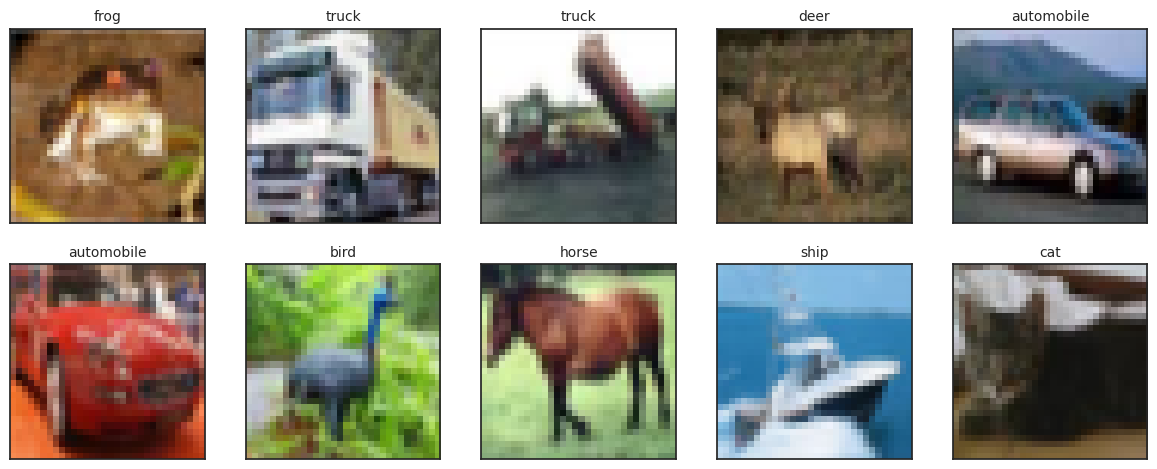

In [7]:

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Set the Seaborn style
sns.set(style='white', context='notebook', font_scale=1.2)

# Visualize the first 25 images from the training set with better quality
plt.figure(figsize=(12, 12))
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ax.set_aspect('equal')
    ax.set_title(class_names[np.argmax(train_labels[i])], fontsize=10)
plt.tight_layout()
plt.show()



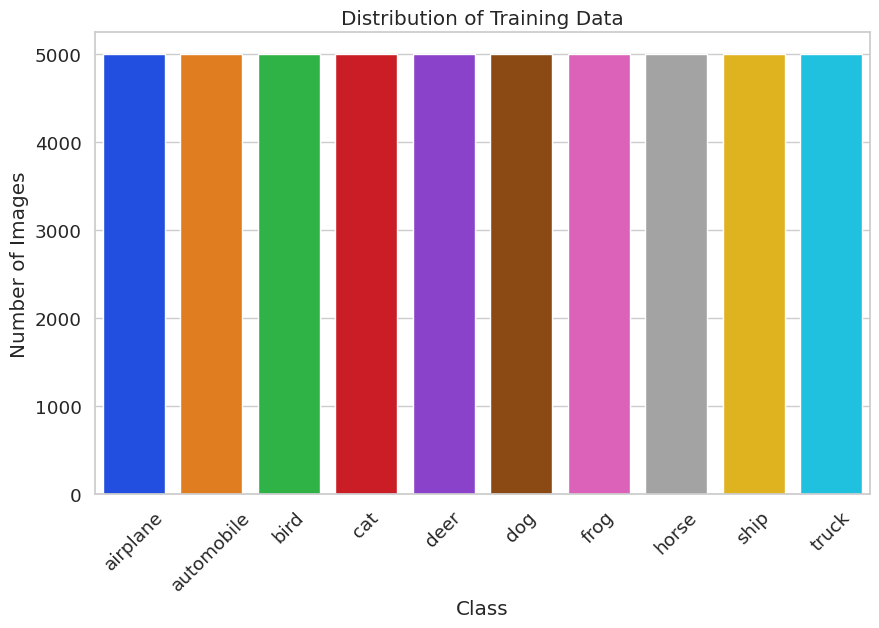

In [8]:
# Plot the distribution of the training dataset
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

# Convert labels from one-hot encoding to class indices
train_labels_indices = np.argmax(train_labels, axis=1)

# Create the count plot with class names as x-axis labels
sns.countplot(x=train_labels_indices, hue=train_labels_indices, palette='bright', legend=False)

plt.title('Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Update x-axis labels with class names
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.show()


### Data Augmentation: ImageDataGenerator is used to augment the training data, which helps in reducing overfitting.



In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
datagen.fit(train_images)

### Loading and Modifying the Pre-trained VGG16 Model

#### Why VGG16?: VGG16 is a well-known deep learning model pre-trained on the ImageNet dataset. Using a pre-trained model helps leverage learned features, making the training faster and potentially more accurate.
#### Freezing layers: Prevents the weights of the VGG16 base model from being updated during training, which is useful when the base model already performs well on similar tasks.

In [10]:
# Load the VGG16 model pre-trained on ImageNet, without the top layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the first 12 layers of VGG16
for layer in vgg16_base.layers[:12]:
    layer.trainable = False

# Unfreeze the remaining layers
for layer in vgg16_base.layers[12:]:
    layer.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Adding Custom Top Layers

##### Custom layers: Add fully connected layers on top of the VGG16 base to tailor the model to the CIFAR-10 classification task.
#### Regularization: Besides l2 regularization, adding l1 or elastic net regularization. These techniques can help prevent overfitting by penalizing large weights.
##### Batch Normalization: Helps in faster convergence and stability during training.
##### Dropout: Prevents overfitting by randomly setting a fraction of input units to 0 at each update during training time.

In [11]:
# Add custom top layers
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.35))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.35))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.35))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.35))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,0

 Total params: 16,148,874 (61.60 MB)

 Trainable params: 13,226,698 (50.46 MB)

 Non-trainable params: 2,922,176 (11.15 MB)

### Compiling the Model

In [12]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Training the Model with Callbacks

##### EarlyStopping: Stops training when the validation loss stops improving, preventing overfitting.
##### ModelCheckpoint: Saves the model with the best validation performance.
##### ReduceLROnPlateau: Reduces the learning rate when the validation performance plateaus, which helps in fine-tuning the learning process.

In [13]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]


# Train the model with data augmentation
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    epochs=200,
                    validation_data=(test_images, test_labels),
                    callbacks=callbacks)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1009 - loss: 61.2322

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 47ms/step - accuracy: 0.1009 - loss: 61.2280 - val_accuracy: 0.0711 - val_loss: 52.7908 - learning_rate: 1.0000e-04
Epoch 2/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1235 - loss: 51.1058

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.1235 - loss: 51.1045 - val_accuracy: 0.1401 - val_loss: 44.9967 - learning_rate: 1.0000e-04
Epoch 3/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1706 - loss: 42.9726

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.1706 - loss: 42.9712 - val_accuracy: 0.2348 - val_loss: 36.0711 - learning_rate: 1.0000e-04
Epoch 4/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1906 - loss: 33.6106

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.1906 - loss: 33.6071 - val_accuracy: 0.2405 - val_loss: 25.3264 - learning_rate: 1.0000e-04
Epoch 5/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2171 - loss: 22.4870

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.2171 - loss: 22.4833 - val_accuracy: 0.2410 - val_loss: 14.0380 - learning_rate: 1.0000e-04
Epoch 6/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2365 - loss: 11.7307

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.2365 - loss: 11.7282 - val_accuracy: 0.3105 - val_loss: 6.2375 - learning_rate: 1.0000e-04
Epoch 7/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2628 - loss: 5.4131

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.2628 - loss: 5.4126 - val_accuracy: 0.4021 - val_loss: 3.4541 - learning_rate: 1.0000e-04
Epoch 8/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3364 - loss: 3.3047

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 38ms/step - accuracy: 0.3364 - loss: 3.3046 - val_accuracy: 0.4491 - val_loss: 2.5046 - learning_rate: 1.0000e-04
Epoch 9/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4152 - loss: 2.6186

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.4152 - loss: 2.6185 - val_accuracy: 0.5195 - val_loss: 2.2316 - learning_rate: 1.0000e-04
Epoch 10/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4769 - loss: 2.3713

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.4769 - loss: 2.3713 - val_accuracy: 0.6080 - val_loss: 1.9869 - learning_rate: 1.0000e-04
Epoch 11/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.5153 - loss: 2.2306 - val_accuracy: 0.5323 - val_loss: 2.2123 - learning_rate: 1.0000e-04
Epoch 12/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5549 - loss: 2.1441

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.5549 - loss: 2.1440 - val_accuracy: 0.6489 - val_loss: 1.8906 - learning_rate: 1.0000e-04
Epoch 13/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5824 - loss: 2.0465

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.5824 - loss: 2.0465 - val_accuracy: 0.6699 - val_loss: 1.7614 - learning_rate: 1.0000e-04
Epoch 14/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6038 - loss: 1.9773

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.6038 - loss: 1.9773 - val_accuracy: 0.7003 - val_loss: 1.6798 - learning_rate: 1.0000e-04
Epoch 15/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6104 - loss: 1.9517 - val_accuracy: 0.6842 - val_loss: 1.7473 - learning_rate: 1.0000e-04
Epoch 16/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6152 - loss: 1.9261

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.6152 - loss: 1.9261 - val_accuracy: 0.6916 - val_loss: 1.6659 - learning_rate: 1.0000e-04
Epoch 17/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6279 - loss: 1.8718 - val_accuracy: 0.6965 - val_loss: 1.6826 - learning_rate: 1.0000e-04
Epoch 18/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6374 - loss: 1.8585

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.6374 - loss: 1.8585 - val_accuracy: 0.7130 - val_loss: 1.6034 - learning_rate: 1.0000e-04
Epoch 19/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.6390 - loss: 1.8309 - val_accuracy: 0.6993 - val_loss: 1.6214 - learning_rate: 1.0000e-04
Epoch 20/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6453 - loss: 1.8130 - val_accuracy: 0.7215 - val_loss: 1.6132 - learning_rate: 1.0000e-04
Epoch 21/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6541 - loss: 1.8037 - val_accuracy: 0.7151 - val_loss: 1.6141 - learning_rate: 1.0000e-04
Epoch 22/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6551 - loss: 1.7976

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.6551 - loss: 1.7976 - val_accuracy: 0.7214 - val_loss: 1.5597 - learning_rate: 1.0000e-04
Epoch 23/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6640 - loss: 1.7493

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6640 - loss: 1.7493 - val_accuracy: 0.7398 - val_loss: 1.5172 - learning_rate: 1.0000e-04
Epoch 24/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6639 - loss: 1.7679 - val_accuracy: 0.7297 - val_loss: 1.5383 - learning_rate: 1.0000e-04
Epoch 25/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6747 - loss: 1.7326 - val_accuracy: 0.7182 - val_loss: 1.6796 - learning_rate: 1.0000e-04
Epoch 26/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6724 - loss: 1.7627 - val_accuracy: 0.7142 - val_loss: 1.5868 - learning_rate: 1.0000e-04
Epoch 27/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6774 - loss: 1.7282

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.6774 - loss: 1.7282 - val_accuracy: 0.7501 - val_loss: 1.4670 - learning_rate: 1.0000e-04
Epoch 28/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.6897 - loss: 1.6813 - val_accuracy: 0.7014 - val_loss: 1.6085 - learning_rate: 1.0000e-04
Epoch 29/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6902 - loss: 1.6868 - val_accuracy: 0.7425 - val_loss: 1.5097 - learning_rate: 1.0000e-04
Epoch 30/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.6913 - loss: 1.6788 - val_accuracy: 0.7425 - val_loss: 1.5818 - learning_rate: 1.0000e-04
Epoch 31/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.6965 - loss: 1.6794 - val_accuracy: 0.7492 - val_loss: 1.5019 - learning_rate: 1.0000e-04
Epoch 32/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.6984 - loss: 1.6589 - val_accuracy: 0.7525 - val_loss: 1.5197 - learning_rate: 1.0000e-04
Epoch 33/200
1562/1563 ━━━━━━━━━━━━━━━━━━

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - accuracy: 0.7281 - loss: 1.4442 - val_accuracy: 0.7807 - val_loss: 1.1710 - learning_rate: 5.0000e-05
Epoch 34/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.7355 - loss: 1.3209 - val_accuracy: 0.7704 - val_loss: 1.1844 - learning_rate: 5.0000e-05
Epoch 35/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7367 - loss: 1.2911

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.7367 - loss: 1.2911 - val_accuracy: 0.7750 - val_loss: 1.1652 - learning_rate: 5.0000e-05
Epoch 36/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7420 - loss: 1.2729 - val_accuracy: 0.7752 - val_loss: 1.1748 - learning_rate: 5.0000e-05
Epoch 37/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7389 - loss: 1.2861 - val_accuracy: 0.7641 - val_loss: 1.2007 - learning_rate: 5.0000e-05
Epoch 38/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7441 - loss: 1.2725

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7441 - loss: 1.2725 - val_accuracy: 0.7763 - val_loss: 1.1522 - learning_rate: 5.0000e-05
Epoch 39/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7491 - loss: 1.2598 - val_accuracy: 0.7752 - val_loss: 1.1803 - learning_rate: 5.0000e-05
Epoch 40/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7455 - loss: 1.2617

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.7455 - loss: 1.2617 - val_accuracy: 0.7814 - val_loss: 1.1182 - learning_rate: 5.0000e-05
Epoch 41/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7538 - loss: 1.2348

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7538 - loss: 1.2348 - val_accuracy: 0.7779 - val_loss: 1.1110 - learning_rate: 5.0000e-05
Epoch 42/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - accuracy: 0.7571 - loss: 1.2186 - val_accuracy: 0.7635 - val_loss: 1.2268 - learning_rate: 5.0000e-05
Epoch 43/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7617 - loss: 1.2079 - val_accuracy: 0.7753 - val_loss: 1.1424 - learning_rate: 5.0000e-05
Epoch 44/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7602 - loss: 1.2023 - val_accuracy: 0.7752 - val_loss: 1.1536 - learning_rate: 5.0000e-05
Epoch 45/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7623 - loss: 1.2004 - val_accuracy: 0.7793 - val_loss: 1.1380 - learning_rate: 5.0000e-05
Epoch 46/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7643 - loss: 1.2011 - val_accuracy: 0.7815 - val_loss: 1.1334 - learning_rate: 5.0000e-05
Epoch 47/200
1562/1563 ━━━━━━━━━━━━━━━━━━

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7770 - loss: 1.0905 - val_accuracy: 0.7965 - val_loss: 0.9504 - learning_rate: 2.5000e-05
Epoch 48/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7824 - loss: 1.0108

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.7824 - loss: 1.0108 - val_accuracy: 0.7926 - val_loss: 0.9330 - learning_rate: 2.5000e-05
Epoch 49/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7833 - loss: 0.9860

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.7833 - loss: 0.9860 - val_accuracy: 0.7923 - val_loss: 0.9204 - learning_rate: 2.5000e-05
Epoch 50/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7866 - loss: 0.9716 - val_accuracy: 0.7865 - val_loss: 0.9667 - learning_rate: 2.5000e-05
Epoch 51/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7853 - loss: 0.9796

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7853 - loss: 0.9796 - val_accuracy: 0.7999 - val_loss: 0.9182 - learning_rate: 2.5000e-05
Epoch 52/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.7927 - loss: 0.9499 - val_accuracy: 0.7966 - val_loss: 0.9581 - learning_rate: 2.5000e-05
Epoch 53/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7931 - loss: 0.9458

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7931 - loss: 0.9458 - val_accuracy: 0.8038 - val_loss: 0.9018 - learning_rate: 2.5000e-05
Epoch 54/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7872 - loss: 0.9466 - val_accuracy: 0.7924 - val_loss: 0.9322 - learning_rate: 2.5000e-05
Epoch 55/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.7935 - loss: 0.9353 - val_accuracy: 0.7958 - val_loss: 0.9250 - learning_rate: 2.5000e-05
Epoch 56/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7941 - loss: 0.9353 - val_accuracy: 0.7928 - val_loss: 0.9400 - learning_rate: 2.5000e-05
Epoch 57/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7986 - loss: 0.9219 - val_accuracy: 0.8027 - val_loss: 0.9048 - learning_rate: 2.5000e-05
Epoch 58/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.7964 - loss: 0.9255 - val_accuracy: 0.7954 - val_loss: 0.9232 - learning_rate: 2.5000e-05
Epoch 59/200
1562/1563 ━━━━━━━━━━━━━━━━━━

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8060 - loss: 0.8690 - val_accuracy: 0.8043 - val_loss: 0.8242 - learning_rate: 1.2500e-05
Epoch 60/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8082 - loss: 0.8193

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.8082 - loss: 0.8193 - val_accuracy: 0.8055 - val_loss: 0.8077 - learning_rate: 1.2500e-05
Epoch 61/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.8107 - loss: 0.8058 - val_accuracy: 0.8060 - val_loss: 0.8081 - learning_rate: 1.2500e-05
Epoch 62/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8099 - loss: 0.7945 - val_accuracy: 0.8021 - val_loss: 0.8321 - learning_rate: 1.2500e-05
Epoch 63/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8119 - loss: 0.7989 - val_accuracy: 0.7976 - val_loss: 0.8276 - learning_rate: 1.2500e-05
Epoch 64/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8222 - loss: 0.7685

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.8222 - loss: 0.7685 - val_accuracy: 0.8041 - val_loss: 0.8076 - learning_rate: 1.2500e-05
Epoch 65/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8143 - loss: 0.7822 - val_accuracy: 0.7980 - val_loss: 0.8423 - learning_rate: 1.2500e-05
Epoch 66/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8212 - loss: 0.7522

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8212 - loss: 0.7522 - val_accuracy: 0.8069 - val_loss: 0.7730 - learning_rate: 6.2500e-06
Epoch 67/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8216 - loss: 0.7341

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.8216 - loss: 0.7341 - val_accuracy: 0.8078 - val_loss: 0.7556 - learning_rate: 6.2500e-06
Epoch 68/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8230 - loss: 0.7145 - val_accuracy: 0.8047 - val_loss: 0.7742 - learning_rate: 6.2500e-06
Epoch 69/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8209 - loss: 0.7212

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8209 - loss: 0.7212 - val_accuracy: 0.8067 - val_loss: 0.7486 - learning_rate: 6.2500e-06
Epoch 70/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.8223 - loss: 0.7067 - val_accuracy: 0.8068 - val_loss: 0.7616 - learning_rate: 6.2500e-06
Epoch 71/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.8219 - loss: 0.7084 - val_accuracy: 0.8049 - val_loss: 0.7686 - learning_rate: 6.2500e-06
Epoch 72/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.8229 - loss: 0.7075 - val_accuracy: 0.8062 - val_loss: 0.7550 - learning_rate: 6.2500e-06
Epoch 73/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8287 - loss: 0.6874

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.8287 - loss: 0.6874 - val_accuracy: 0.8061 - val_loss: 0.7469 - learning_rate: 6.2500e-06
Epoch 74/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.8253 - loss: 0.6947 - val_accuracy: 0.8073 - val_loss: 0.7672 - learning_rate: 6.2500e-06
Epoch 75/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.8277 - loss: 0.6895 - val_accuracy: 0.8018 - val_loss: 0.7739 - learning_rate: 6.2500e-06
Epoch 76/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.8313 - loss: 0.6775 - val_accuracy: 0.8026 - val_loss: 0.7724 - learning_rate: 6.2500e-06
Epoch 77/200
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8220 - loss: 0.7018

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8220 - loss: 0.7018 - val_accuracy: 0.8089 - val_loss: 0.7350 - learning_rate: 6.2500e-06
Epoch 78/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8305 - loss: 0.6810 - val_accuracy: 0.8042 - val_loss: 0.7543 - learning_rate: 6.2500e-06
Epoch 79/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8304 - loss: 0.6881 - val_accuracy: 0.8004 - val_loss: 0.7850 - learning_rate: 6.2500e-06
Epoch 80/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8237 - loss: 0.6973 - val_accuracy: 0.8043 - val_loss: 0.7658 - learning_rate: 6.2500e-06
Epoch 81/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8280 - loss: 0.6888

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8280 - loss: 0.6888 - val_accuracy: 0.8075 - val_loss: 0.7277 - learning_rate: 6.2500e-06
Epoch 82/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8266 - loss: 0.6910 - val_accuracy: 0.8031 - val_loss: 0.7809 - learning_rate: 6.2500e-06
Epoch 83/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8297 - loss: 0.6779 - val_accuracy: 0.8088 - val_loss: 0.7418 - learning_rate: 6.2500e-06
Epoch 84/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.8276 - loss: 0.6885 - val_accuracy: 0.8071 - val_loss: 0.7576 - learning_rate: 6.2500e-06
Epoch 85/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.8280 - loss: 0.6783 - val_accuracy: 0.8075 - val_loss: 0.7496 - learning_rate: 6.2500e-06
Epoch 86/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8290 - loss: 0.6847 - val_accuracy: 0.8059 - val_loss: 0.7593 - learning_rate: 6.2500e-06
Epoch 87/200
1563/1563 ━━━━━━━━━━━━━━━━━━

### Evaluating the Model


#### Measures the model's performance on the test set to see how well it generalizes to new, unseen data

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8047 - loss: 0.7356
Test accuracy: 0.8075


### Plotting Training and Validation Metrics

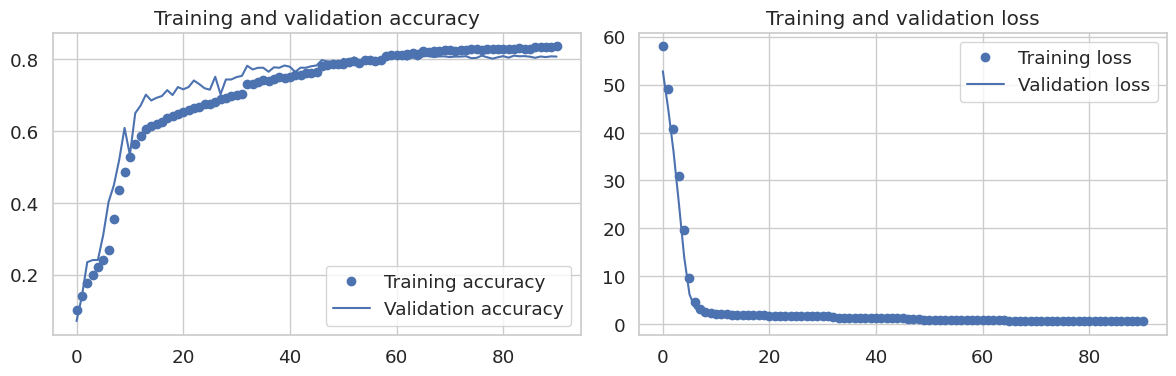

In [15]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Save the trained model
model.save('cifar10_vgg16_model.h5')

In [17]:
from google.colab import drive
drive.mount('/content/drive')

# Guardar el modelo en Google Drive
model.save('/content/drive/My Drive/cifar10_vgg16_model.h5')


Mounted at /content/drive


**Conclusions**

It has been created a well-generalized image classification model using the CIFAR-10 dataset and VGG16 model.

The model has demonstrated a promising performance with an accuracy of 83.70%. On the validation set, the model achieved a slightly lower accuracy of 80.75%.

Transfer Learning Alternatives: Experiment with other pre-trained models, to see if they perform better.
